<a href="https://colab.research.google.com/github/melodymeow/Mortgage_Defaut_Analysis/blob/master/Melody_PYTH_225_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Historical Mortage Performance**
this project is to


1.   Clean mortgage data
2.   append HPI and unemployment data
3. calculate prepayment/default
4. correlationb between prepayment, default with HPI and unemployment data
5. graph any state the delinquency rate against that state's HPI data





In [0]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

print('import successful')


import successful


# **Import Data**

In [0]:
#upload local data to colab folder in order to import the data

#import deqlinquency data from federal reserve by quarter
url = 'https://www.federalreserve.gov/releases/chargeoff/delallsa.htm'
html = requests.get(url).content
delinquency_list = pd.read_html(html)
dq = delinquency_list[2]
dq.columns = ['Date','All Real Estate Loan','Residential','Commercial','Farmland','All Consumer','Credit Card','Other Consumer','Leases','C&I Loans','Agricultural Loans','Total Loans and Leases']
cols = dq.columns.drop('Date')
dq[cols] = dq[cols].apply(pd.to_numeric,errors = 'coerce')

#delinquency data by states and year from consumer bureau 
dqstate_90plus = pd.read_csv('90daysDQ.csv')
dqstate_30to89 = pd.read_csv('30-89daysDQ.csv')

#import HPI Data
hpi = pd.read_csv('HPI_AT_state.csv',header=None)
hpi.columns = ['States','Year','Quarter','HPI']
hpi['HPI'] = pd.to_numeric(hpi['HPI'],errors = 'coerce')

#unemployment data from department of bureau
unemployment = pd.read_excel('unemployment data.xlsx')
unemployment = unemployment.tail(12)
unemployment.columns = unemployment.iloc[0]
unemployment = unemployment[1:]
unemployment.set_index('Year',drop = True,inplace = True)


In [0]:
#date converter
def convert_to_last_day_of_quarter(val):
  year, quarter = val.split(':')

 # convert year to int
  year = int(year)

  # convert quarter to int
  quarter = int(quarter)

  # convert to datetime
  year_dt = datetime(year, 1, 1)

  # get the last month of quarter
  month = quarter * 3

  # update datetime
  last_day = year_dt.replace(month=month) + pd.tseries.offsets.QuarterEnd()

  # return the last day of quarter in python's datetime object
  return last_day.to_pydatetime()

def convert_to_last_day_of_month(val):
  year,month = val.split('-')
  year = int(year)
  month = int(month)
  last_day = datetime(year,month,1) + pd.tseries.offsets.MonthEnd()
  return last_day.to_pydatetime()




**Data Preview**

In [0]:
dq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    140 non-null    object 
 1   All Real Estate Loan    132 non-null    float64
 2   Residential             116 non-null    float64
 3   Commercial              116 non-null    float64
 4   Farmland                116 non-null    float64
 5   All Consumer            132 non-null    float64
 6   Credit Card             116 non-null    float64
 7   Other Consumer          116 non-null    float64
 8   Leases                  132 non-null    float64
 9   C&I Loans               132 non-null    float64
 10  Agricultural Loans      132 non-null    float64
 11  Total Loans and Leases  140 non-null    float64
dtypes: float64(11), object(1)
memory usage: 13.2+ KB


In [0]:
dqstate_30to89.info()
dqstate_30to89.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 144 entries, RegionType to 2019-09
dtypes: float64(141), object(3)
memory usage: 58.6+ KB


Index(['RegionType', 'Name', 'FIPSCode', '2008-01', '2008-02', '2008-03',
       '2008-04', '2008-05', '2008-06', '2008-07',
       ...
       '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
       '2019-06', '2019-07', '2019-08', '2019-09'],
      dtype='object', length=144)

In [0]:
hpi['Date'] = hpi[['Year','Quarter']].astype(str).apply(lambda x:':'.join(x),axis=1)
hpi['Date'] = hpi['Date'].apply(convert_to_last_day_of_quarter)


In [0]:
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 2010 to 2020
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Jan     11 non-null     object
 1   Feb     11 non-null     object
 2   Mar     11 non-null     object
 3   Apr     10 non-null     object
 4   May     10 non-null     object
 5   Jun     10 non-null     object
 6   Jul     10 non-null     object
 7   Aug     10 non-null     object
 8   Sep     10 non-null     object
 9   Oct     10 non-null     object
 10  Nov     10 non-null     object
 11  Dec     10 non-null     object
dtypes: object(12)
memory usage: 1.1+ KB


# **Data Cleaning**

Goal here is to convert the date to Year-Quarter, make column name to be consistent etc

In [0]:
#clean up deqlinquency data: adding year and quarter, and move them to the front
#then drop Date column to index
dq[['year','quarter']] = dq['Date'].str.split(':',expand=True)
dq.year = dq.year.astype(int)
dq.quarter = 'Q' + dq.quarter
cols = dq.columns.tolist()
cols = cols[-2:] + cols[:-2]
dq = dq[cols]
dq['Date'] = dq['Date'].apply(convert_to_last_day_of_quarter)
dq.set_index('Date',drop = False, inplace = True)

In [0]:
# clean up delinquency data by states
def state_abbrev(states):
  us_state_abbrev = {
      'Alabama': 'AL',
      'Alaska': 'AK',
      'American Samoa': 'AS',
      'Arizona': 'AZ',
      'Arkansas': 'AR',
      'California': 'CA',
      'Colorado': 'CO',
      'Connecticut': 'CT',
      'Delaware': 'DE',
      'District of Columbia': 'DC',
      'Florida': 'FL',
      'Georgia': 'GA',
      'Guam': 'GU',
      'Hawaii': 'HI',
      'Idaho': 'ID',
      'Illinois': 'IL',
      'Indiana': 'IN',
      'Iowa': 'IA',
      'Kansas': 'KS',
      'Kentucky': 'KY',
      'Louisiana': 'LA',
      'Maine': 'ME',
      'Maryland': 'MD',
      'Massachusetts': 'MA',
      'Michigan': 'MI',
      'Minnesota': 'MN',
      'Mississippi': 'MS',
      'Missouri': 'MO',
      'Montana': 'MT',
      'Nebraska': 'NE',
      'Nevada': 'NV',
      'New Hampshire': 'NH',
      'New Jersey': 'NJ',
      'New Mexico': 'NM',
      'New York': 'NY',
      'North Carolina': 'NC',
      'North Dakota': 'ND',
      'Northern Mariana Islands':'MP',
      'Ohio': 'OH',
      'Oklahoma': 'OK',
      'Oregon': 'OR',
      'Pennsylvania': 'PA',
      'Puerto Rico': 'PR',
      'Rhode Island': 'RI',
      'South Carolina': 'SC',
      'South Dakota': 'SD',
      'Tennessee': 'TN',
      'Texas': 'TX',
      'Utah': 'UT',
      'Vermont': 'VT',
      'Virgin Islands': 'VI',
      'Virginia': 'VA',
      'Washington': 'WA',
      'West Virginia': 'WV',
      'Wisconsin': 'WI',
      'Wyoming': 'WY',
      'United States': 'US'}
  return us_state_abbrev.get(states,'Not Found')
    

dqstate_30to89['Name'] = dqstate_30to89['Name'].map(state_abbrev)
dqstate_30to89.rename(columns={'Name':'States'},inplace=True)
dqstate_30to89.set_index('States',drop=True,inplace=True)



In [0]:
#transpose dataframe
dqstate_30to89.drop(['RegionType','FIPSCode'],axis=1,inplace=True)
dqstate_30to89 = dqstate_30to89.transpose()


In [0]:
#convert obj to numeric in the dataframe
cols = dqstate_30to89.columns
dqstate_30to89[cols] = dqstate_30to89[cols].apply(pd.to_numeric,errors = 'coerce')

dqstate_30to89.reset_index(inplace=True)
dqstate_30to89['index'] = dqstate_30to89['index'].apply(convert_to_last_day_of_month)
dqstate_30to89.set_index('index',drop = True,inplace=True)


In [0]:
#

# **Data Visualization**

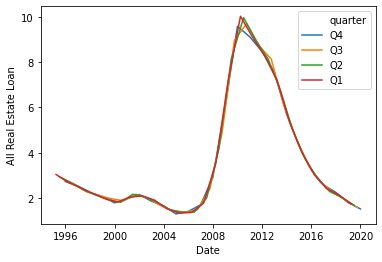

In [0]:
#Graph delinquency data
# plt.plot('Date','All Real Estate Loan',data = dq.head(100))
# plt.title('All Real Estate Loan Delinquency Rate')
# plt.ylabel('Delinquency Rate (%)')
# plt.show()
sns.lineplot('Date','All Real Estate Loan',data = dq.head(100),hue='quarter')


Text(0.5, 1.0, 'Delinquency Rate by States')

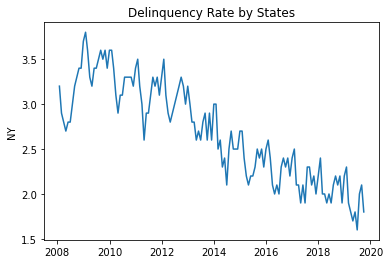

In [0]:
#delinquency graph by state
# plt.plot(dqstate_30to89.index.values,'US',data=dqstate_30to89)
# plt.title('Delinquency Rate by State')
# plt.ylabel('Delinquency Rate (%)')
# plt.show()

ax = sns.lineplot(x=dqstate_30to89.index.values,y='NY',data = dqstate_30to89)
plt.title('Delinquency Rate by States')

-0.7251715038781731

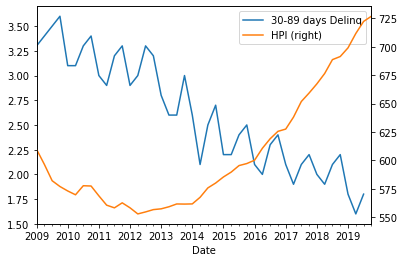

In [0]:
#get subset of dataframe and merge two dataframe
ny_hpi = hpi.loc[hpi['States']=='NY'].loc[hpi['Year']>2008]
ny_hpi_dq = ny_hpi.join(dqstate_30to89['NY'],on='Date').rename(columns={'NY':'30-89 days Delinq'})

ax = ny_hpi_dq.plot('Date','30-89 days Delinq')
ny_hpi_dq.plot('Date','HPI',secondary_y=True,ax=ax)
#sns.pairplot(ny_hpi_dq)
ny_hpi_dq['30-89 days Delinq'].corr(ny_hpi_dq['HPI'])
